Plot white light edges for the updated data provided by Hongfan. Save them for multiple events.

In [6]:
import numpy as np
import pandas as pd
import scipy.linalg as la
import scipy.sparse as sparse
import matplotlib.pyplot as plt

import opinf

In [7]:
import re
import os

In [8]:
from multiprocessing import Pool
from itertools import repeat

In [9]:
%matplotlib inline

In [10]:
def load_edge_data_blobfree(eventID):
    edge_data = np.load("../WhiteLight/edge_data/CR{}_stacked_edge_blobfree.npy".format(eventID))
    simID_data = np.load("../WhiteLight/edge_data/CR{}_SimID4edge.npy".format(eventID))
    
    all_sims = []
    
    for s in simID_data:
        mm = re.search("run\d\d\d_AWSoM2T", s)
        all_sims.append(int(mm.group().split("run")[1].split("_")[0]))
    
    return edge_data, np.array(all_sims)

In [11]:
ed_2161, sd_2161 = load_edge_data_blobfree(2161)

In [12]:
nTimes = ed_2161.shape[0]
nTimes

90

In [13]:
nTheta_2161 = ed_2161.shape[1]
nTheta_2161

160

In [14]:
nSims_2161 = ed_2161.shape[2]
nSims_2161

278

**Event: Start, End(x out of 512)**

~~CR2154: 50, 450~~

CR2161: 160,320

~~CR2192: 90, 275~~

In [15]:
theta_s_2161, theta_e_2161 = np.linspace(0, 360, 512)[160] + 1.2 * 180 - 360, np.linspace(0, 360, 512)[320] + 1.2 * 180 - 360
print("Range of angles for CR2161: {} {}".format(theta_s_2161, theta_e_2161))

Range of angles for CR2161: -31.279843444227026 81.44031311154595


In [16]:
theta_grid = np.linspace(np.ceil(theta_s_2161), np.ceil(theta_e_2161), nTheta_2161)
theta_grid

array([-31.        , -30.28930818, -29.57861635, -28.86792453,
       -28.1572327 , -27.44654088, -26.73584906, -26.02515723,
       -25.31446541, -24.60377358, -23.89308176, -23.18238994,
       -22.47169811, -21.76100629, -21.05031447, -20.33962264,
       -19.62893082, -18.91823899, -18.20754717, -17.49685535,
       -16.78616352, -16.0754717 , -15.36477987, -14.65408805,
       -13.94339623, -13.2327044 , -12.52201258, -11.81132075,
       -11.10062893, -10.38993711,  -9.67924528,  -8.96855346,
        -8.25786164,  -7.54716981,  -6.83647799,  -6.12578616,
        -5.41509434,  -4.70440252,  -3.99371069,  -3.28301887,
        -2.57232704,  -1.86163522,  -1.1509434 ,  -0.44025157,
         0.27044025,   0.98113208,   1.6918239 ,   2.40251572,
         3.11320755,   3.82389937,   4.53459119,   5.24528302,
         5.95597484,   6.66666667,   7.37735849,   8.08805031,
         8.79874214,   9.50943396,  10.22012579,  10.93081761,
        11.64150943,  12.35220126,  13.06289308,  13.77

In [17]:
height_flattened=128

In [18]:
actualTimes = np.arange(2, 182, 2)

In [19]:
# convert pixel values to Cartesian, then get correct R and theta values from there. Show on a polar plot!

In [20]:
circles_disk_obs = (518, 532, 67)
circles_scope_obs = (518, 532, 384)

In [21]:
def Polar_to_Cartesian(edge, start_angle, end_angle, height, width, circles_disk, circles_scope):
    theta = np.arange(0, 2 * np.pi, 2 * np.pi / width)[start_angle:end_angle]
    # Coordinates of disk and telescope center
    circle_x = circles_disk[0]
    circle_y = circles_disk[1]
    # Radius of disk and telescope
    r_disk = circles_disk[2]
    r_scope = circles_scope[2]
    Xp = circle_x + r_disk * np.cos(theta + 1.2 * np.pi)
    Yp = circle_y + r_disk * np.sin(theta + 1.2 * np.pi)
    Xi = circle_x + r_scope * np.cos(theta + 1.2 * np.pi)
    Yi = circle_y + r_scope * np.sin(theta + 1.2 * np.pi)
    r = edge / height
    X = Xp + ( Xi - Xp ) * r
    Y = Yp + ( Yi - Yp ) * r
    return (X,Y)

Now run the polar conversion for all the edges. Make a side by side plot for visualization first. We can also set the $\theta$ values to a common range as we had already prespecified. For now arguments like start and end angle are event-specific.

In [22]:
def getRValues(edge_data_matrix, simIdx=0, minStartIdx=20):
    
    edges_sim = edge_data_matrix[minStartIdx:, :, simIdx]
    
    nTimes, nThetas = edges_sim.shape[0], edges_sim.shape[1]
    
    r_vals = np.zeros((nTimes, nThetas))
    theta_vals = np.zeros((nTimes, nThetas))
    
    for i in range(nTimes):
        xi, yi   = Polar_to_Cartesian(edges_sim[i, :], 
                   start_angle = 160, 
                   end_angle = 320, 
                   height=128, 
                   width=512, 
                   circles_disk=(149,149,19), 
                   circles_scope=(149,149,110))
        
        xi_norm, yi_norm = 64 * (xi/300) - 32, 64 * (yi/300) - 32
        theta_vals[i, :] = np.arctan2(yi_norm, xi_norm)
    
        r_vals[i, :] = np.sqrt(xi_norm**2 + yi_norm**2)
    
    return r_vals, theta_vals

In [23]:
def getRValuesObs(edge_data_matrix, cd=circles_disk_obs, co=circles_scope_obs):
    
    nTimes, nThetas = edge_data_matrix.shape[0], edge_data_matrix.shape[1]
    
    r_vals = np.zeros((nTimes, nThetas))
    theta_vals = np.zeros((nTimes, nThetas))
    
    for i in range(nTimes):
        xi, yi   = Polar_to_Cartesian(edge_data_matrix[i, :], 
                   start_angle = 160,
                   end_angle = 290,
                   height=128, 
                   width=512, 
                   circles_disk=cd, 
                   circles_scope=co)
        
        xi_norm, yi_norm = 64 * (xi/1024) - 32, 64 * (yi/1024) - 32
        theta_vals[i, :] = np.arctan2(yi_norm, xi_norm)
    
        r_vals[i, :] = np.sqrt(xi_norm**2 + yi_norm**2)
    
    return r_vals, theta_vals

In [24]:
r_vals_s31, theta_vals_s31 = getRValues(ed_2161, simIdx=0, minStartIdx = 0)

In [25]:
r_vals_s51, theta_vals_s51 = getRValues(ed_2161, simIdx=20, minStartIdx = 0)

In [26]:
r_vals_s31.shape

(90, 160)

Try to make a plot every 4 minutes or 8 minutes or something? Get a sense of entire edge evolution.

In [27]:
# np.arange(20, 89, 4)

In [28]:
r_vals_s51.min()

3.751635421809057

In [29]:
r_vals_s51.max()

22.824017489776132

In [30]:
min_edge_by_time = np.min(ed_2161[:, :, 20], axis=1)
min_edge_by_time

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       6.43522918e-03, 2.68141524e-02, 9.28055763e-02, 1.34837861e-01,
       1.34837861e-01, 1.41229026e-01, 1.41229026e-01, 1.41229026e-01,
       1.71018498e-01, 2.69968170e+00, 4.31852586e+00, 5.32960077e+00,
       6.35724095e+00, 7.05596189e+00, 7.05596189e+00, 9.39575157e+00,
       9.39575157e+00, 9.39575157e+00, 1.21173378e+01, 1.21173378e+01,
       1.21173378e+01, 1.54615786e+01, 1.54615786e+01, 1.54615786e+01,
       1.90581939e+01, 1.90581939e+01, 1.90581939e+01, 1.91527824e+01,
       2.16714455e+01, 2.30693512e+01, 2.41435187e+01, 2.62281564e+01,
       2.66278746e+01, 2.76134388e+01, 2.98748852e+01, 3.11266053e+01,
      

In [31]:
max_edge_by_time = np.max(ed_2161[:, :, 20], axis=1)
max_edge_by_time

array([  0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   1.64439525,   3.10926812,   4.06517877,
         6.60745012,   8.11160933,  10.03807881,  11.0762428 ,
        13.09762828,  15.01916946,  17.35478652,  19.25180696,
        20.21344525,  22.1356426 ,  23.88817582,  25.84273095,
        27.68820702,  30.3279874 ,  32.08906632,  33.34642546,
        34.91741706,  36.58000503,  38.01043643,  40.71202564,
        42.19921547,  43.85798718,  46.52172931,  47.50927306,
        49.66377978,  52.14352995,  53.05137967,  54.63503635,
        58.09990551,  58.63635792,  60.72965235,  62.30029812,
        64.94886716,  67.42493525,  68.20901048,  71.2447546 ,
        72.0792688 ,  73.6592429 ,  76.31407597,  77.68724835,
        79.30304326,  81.95452271,  82.94330387,  85.06854117,
        86.28403759,  87.9246293 ,  89.09748042,  91.48

In [32]:
tMinIdx = np.where(min_edge_by_time > 0)[0][0]
tMin = np.linspace(2, 180, 90)[tMinIdx]

print(tMinIdx, tMin)

20 42.0


In [33]:
tMaxIdx = np.where(max_edge_by_time > 120)[0][0]
tMax = np.linspace(2, 180, 90)[tMaxIdx]

print(tMaxIdx, tMax)

83 168.0


In [34]:
def getTMinTMax(edge_data_matrix, simIdx=0):
    edges_sim = edge_data_matrix[:, :, simIdx]
    
    min_edge_by_time = np.min(edges_sim, axis=1)
    max_edge_by_time = np.max(edges_sim, axis=1)
    
    tMinIdx = np.where(min_edge_by_time > 0)[0][0]
    tMin = np.linspace(2, 180, 90)[tMinIdx]
    
    if np.max(edges_sim) > 120:
        tMaxIdx = np.where(max_edge_by_time > 120)[0][0]
        tMax = np.linspace(2, 180, 90)[tMaxIdx]
    else:
        tMaxIdx = 89
        tMax = 180

    return tMinIdx, tMin, tMaxIdx, tMax

In [35]:
np.max(ed_2161[:, :, 1])

42.43977590693392

In [36]:
getTMinTMax(ed_2161, simIdx=0)

(11, 24.0, 79, 160.0)

In [37]:
getTMinTMax(ed_2161, simIdx=20)

(20, 42.0, 83, 168.0)

Plotting function: take in an edge data array, call a routine to get min and max times and adjust plotting times accordingly.

In [38]:
edge_save_dir = "./edges_blobfree_varying_theta"

In [39]:
def plotCartesianPolarEdges(edge_data_matrix, sim_data, theta=theta_grid, simIdx=0, saveFig=False):
    
    # get Sim ID
    simID = sim_data[simIdx]
    
    # get minimum and max bounds (i.e. where edge appears and where edge is very close to boundary)
    tMinIdx, tMin, tMaxIdx, tMax = getTMinTMax(edge_data_matrix, simIdx=simIdx)
        
    # convert edge data to polar coordinates
    r_vals, theta_vals = getRValues(edge_data_matrix, simIdx=simIdx, minStartIdx=0)
    
    # sim times (list all times)
    all_times = np.linspace(2, 180, 90)
    
    # filter based on tMinIdx and tMaxIdx
    valid_times = all_times[tMinIdx:(tMaxIdx + 1)]
    
    valid_times_to_plot = np.arange(tMin, tMax + 2, step=6)
    
    valid_time_idx = np.array([np.where(all_times == i)[0][0] for i in valid_times_to_plot])
    
    #     return valid_times_to_plot
    
    
    fig = plt.figure(figsize=(12, 6))
    ax1 = plt.subplot(121)
    ax2 = plt.subplot(122, projection='polar')
        
    color = iter(plt.cm.jet(np.linspace(0, 1, len(valid_times_to_plot))))
    
    for i, j in enumerate(valid_time_idx):
        # ax1.plot(theta_vals[j, :] * (180 / np.pi), r_vals[j, :], color=next(color), label=fr"$u(t_{{{int(valid_times_to_plot[i])}}})$") # variable theta for each time??
        ax1.plot(theta, r_vals[j, :], color=next(color), label=fr"$u(t_{{{int(valid_times_to_plot[i])}}})$") # constant 
        # range of theta (usual plot)
        

    ax1.set_xlabel(r"$θ (deg)$")
    ax1.set_ylabel(r"$r_{edge}(t) \; R_s$")
    ax1.set_xlim(theta[0], theta[-1])
    ax1.set_ylim(4.05, 24)
    ax1.legend(loc=(1.05, .05))
    ax1.set_title("Sim {:03d}".format(simID))

    color = iter(plt.cm.jet(np.linspace(0, 1, len(valid_times_to_plot))))
    
    for i, j in enumerate(valid_time_idx):
        # ax2.plot(theta_vals[j, :], r_vals[j, :], color=next(color)) # variable theta for each time?
        ax2.plot(theta * np.pi/180, r_vals[j, :], color=next(color)) # constant range of theta (usual plot)

    ax2.set_rlabel_position(120)
    ax2.tick_params(axis='both', which='major', labelsize=10)
    ax2.set_rmax(24)
    ax2.grid(True)


    fig.tight_layout()
    
    plt.style.use("dark_background")
    if saveFig:
        plt.savefig(os.path.join(edge_save_dir, "run_{:03d}.png".format(simID)),
                   bbox_inches="tight", pad_inches=0)
        print("Saved image for Sim {:03d}".format(simID))
        plt.close()

In [40]:
plt.rc("axes.spines", right=True, top=True)
plt.rc("figure", dpi=300, 
       figsize=(9, 3)
      )
plt.rc("font", family="serif")
plt.rc("legend", edgecolor="none", frameon=True)
# plt.rc("text", usetex=True)

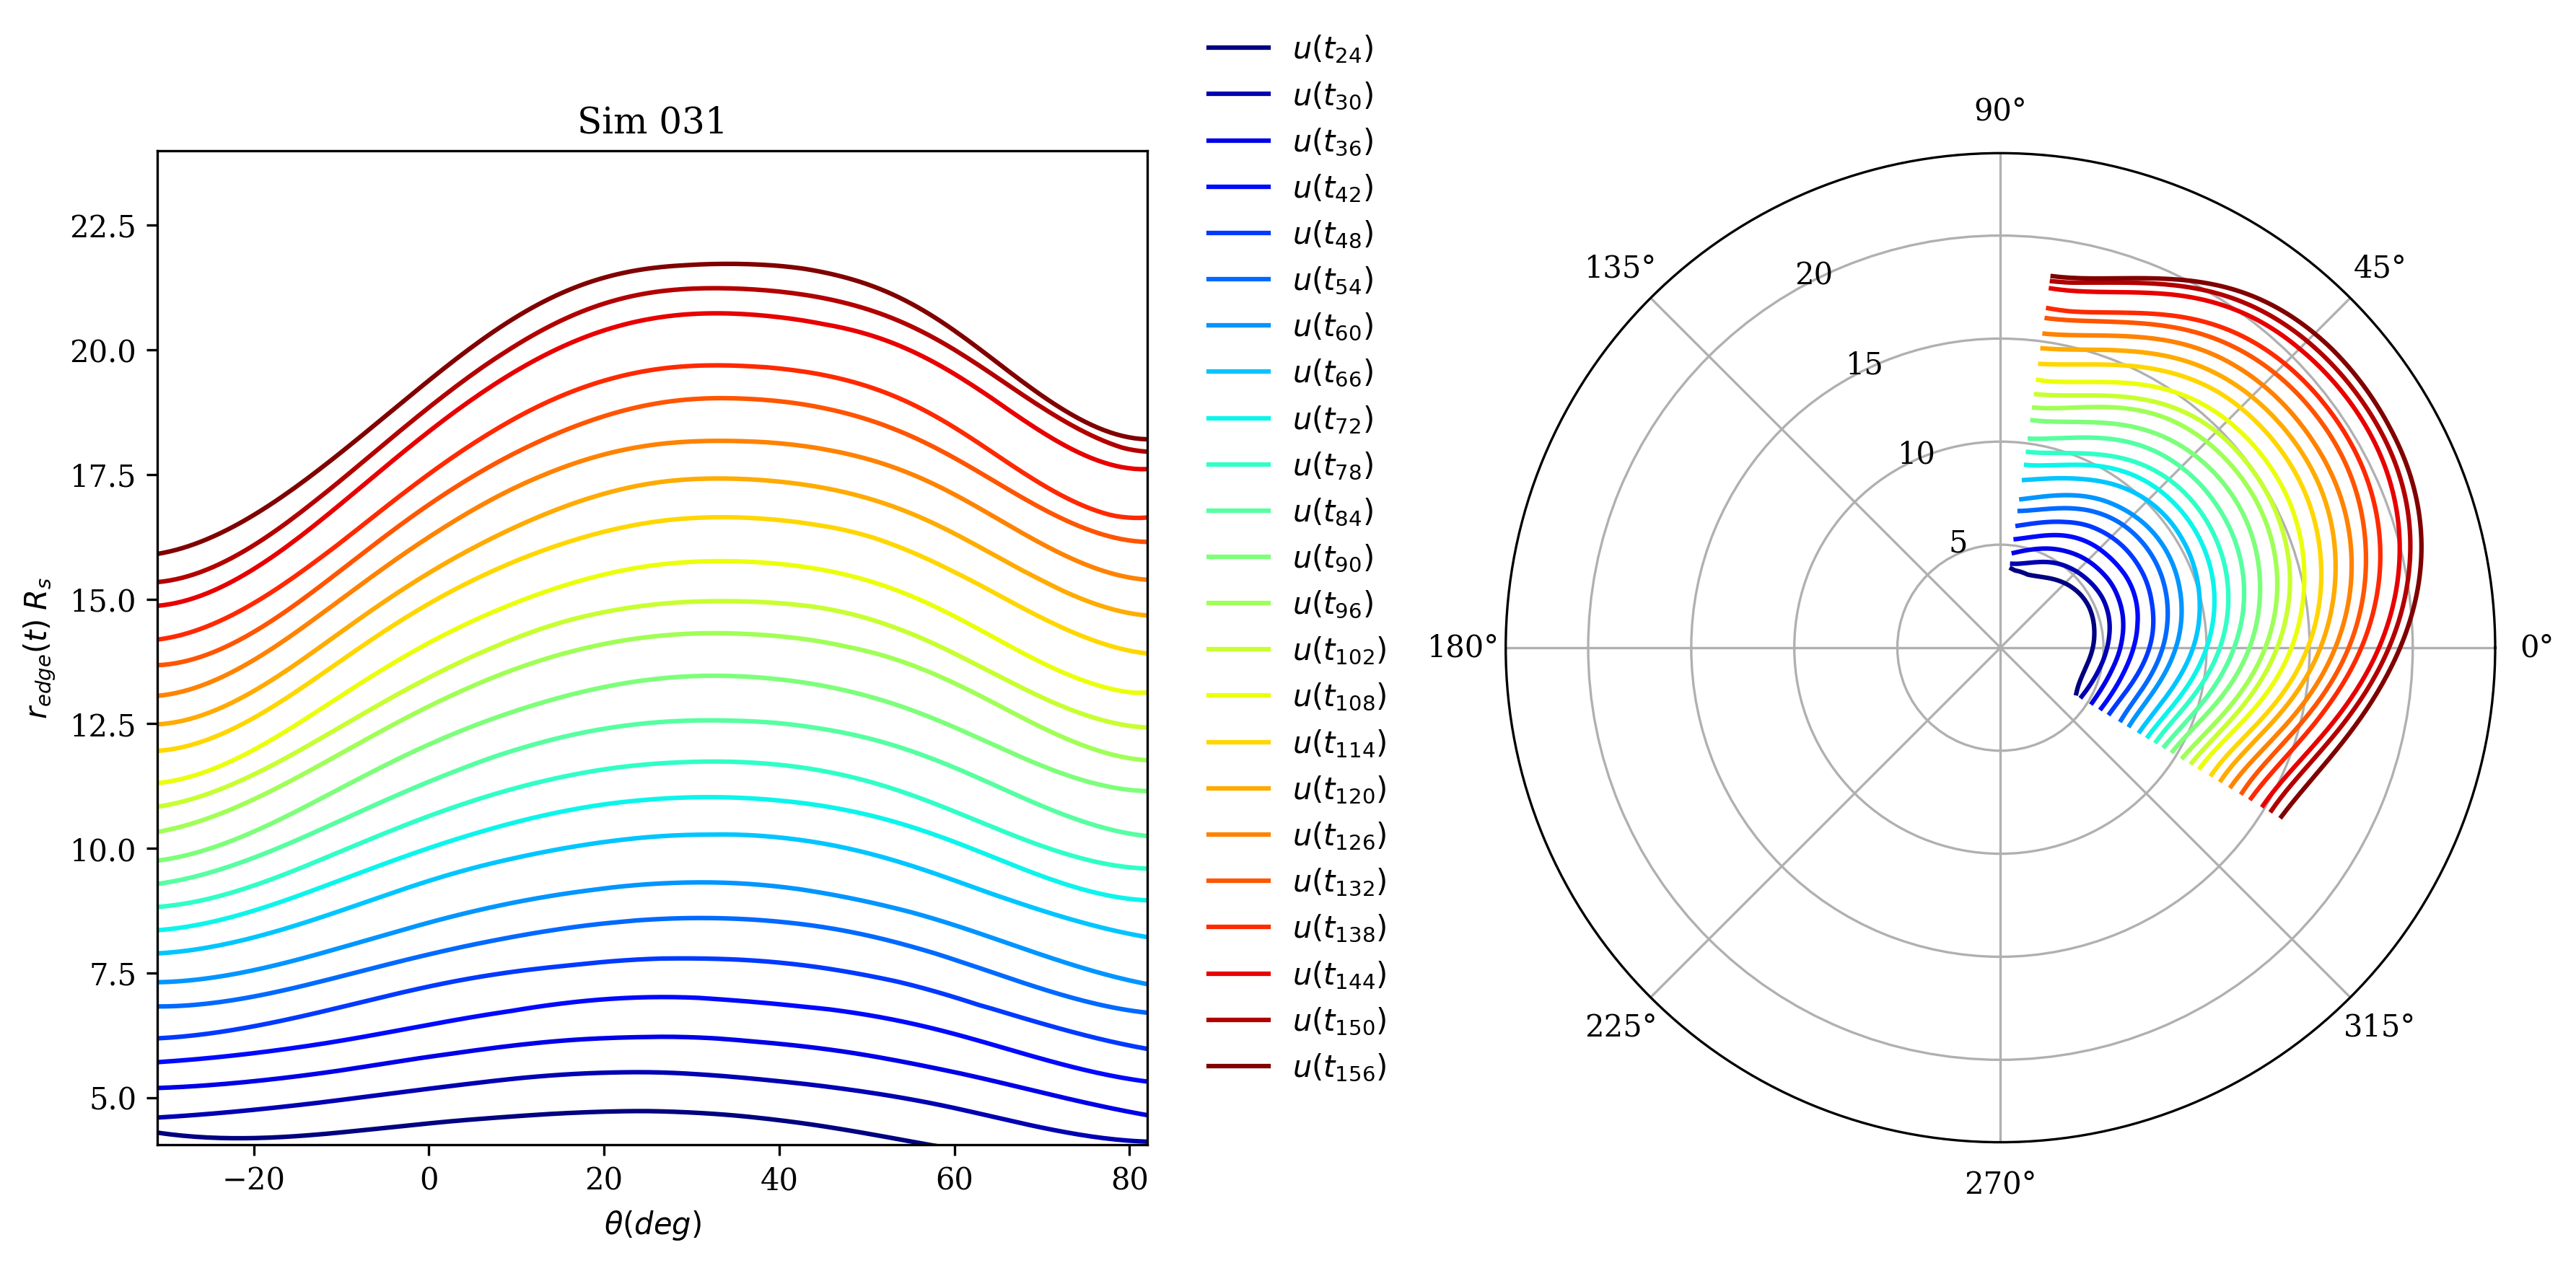

In [41]:
plotCartesianPolarEdges(ed_2161, sd_2161, theta=theta_grid, simIdx=0)

In [42]:
# plotCartesianPolarEdges(ed_2161, sd_2161, theta=theta_grid, simIdx=274, saveFig=True)

In [43]:
# # Comment out after use
# for i in range(len(sd_2161)):
#     plotCartesianPolarEdges(ed_2161, sd_2161, theta=theta_grid, simIdx=i, saveFig=True)

**Quick plot of CR2161 Observations?**

CR2161: start_angle = 160, end_angle = 290 

In [44]:
obs_time_CR2161 = 62 + np.cumsum(np.array([0, 12, 12, 24, 12, 12, 12, 12, 12]))  
sim_idx_CR2161 = (obs_time_CR2161 / 2 - 1).astype(np.int64)

print(obs_time_CR2161)
print(sim_idx_CR2161)

[ 62  74  86 110 122 134 146 158 170]
[30 36 42 54 60 66 72 78 84]


In [45]:
edge_obs_raw = np.load("../WhiteLight/edge_data/CR2161_edge_obs.npy")

In [46]:
nTimesObs, nThetaObs = edge_obs_raw.shape
print(nTimesObs)
print(nThetaObs)

13
130


In [47]:
theta_s_2161_obs, theta_e_2161_obs = np.linspace(0, 360, 512)[160] + 1.2 * 180 - 360, np.linspace(0, 360, 512)[290] + 1.2 * 180 - 360
print("Range of angles for CR2161: {} {}".format(theta_s_2161_obs, theta_e_2161_obs))

Range of angles for CR2161: -31.279843444227026 60.30528375733854


In [48]:
theta_grid_obs = np.linspace(np.ceil(theta_s_2161_obs), np.ceil(theta_e_2161_obs), nThetaObs)

In [49]:
r_vals_obs, theta_vals_obs = getRValuesObs(edge_obs_raw)

In [50]:
theta_vals_obs * (180 / np.pi)

array([[-19.35875055, -18.57318637, -17.79425984, ...,  61.46256468,
         62.00097966,  62.53917996],
       [-20.97386072, -20.17305703, -19.37810686, ...,  61.4261485 ,
         61.91596594,  62.40319283],
       [-22.61731075, -21.82138013, -21.02986526, ...,  60.37689332,
         60.94979893,  61.52149294],
       ...,
       [-26.98304775, -26.24634767, -25.51101741, ...,  59.09911746,
         59.74038444,  60.38122238],
       [-27.42181157, -26.66840038, -25.91686056, ...,  59.12587614,
         59.77811943,  60.42987802],
       [-27.32720402, -26.60015966, -25.87400508, ...,  59.0572566 ,
         59.70939513,  60.36091568]])

In [51]:
np.arange(62, 172, step=12)

array([ 62,  74,  86,  98, 110, 122, 134, 146, 158, 170])

In [52]:
def plotCartesianPolarEdgesObs(edge_data_matrix, theta=theta_grid_obs, saveFig=False):
    
    # get minimum and max bounds (fixed for obs)
    tMinIdx = 30
    tMin = 62
    tMaxIdx = 84
    tMax = 170
        
    # convert edge data to polar coordinates
    r_vals, theta_vals = getRValuesObs(edge_data_matrix)
    
    # sim times (list all times)
    all_times = np.linspace(2, 180, 90)
    
    # filter based on tMinIdx and tMaxIdx
    valid_times = all_times[tMinIdx:(tMaxIdx + 1)]
    
    valid_times_to_plot = 62 + np.cumsum(np.array([0, 12, 12, 24, 12, 12, 12, 12, 12]))
    
    valid_time_idx = (valid_times_to_plot / 2 - 1).astype(np.int64)
    
    fig = plt.figure(figsize=(12, 6))
    ax1 = plt.subplot(121)
    ax2 = plt.subplot(122, projection='polar')
        
    color = iter(plt.cm.jet(np.linspace(0, 1, len(valid_times_to_plot))))
    
    for i, j in enumerate(valid_time_idx):
        # ax1.plot(theta_vals[j, :] * (180 / np.pi), r_vals[j, :], color=next(color), label=fr"$u(t_{{{int(valid_times_to_plot[i])}}})$") # variable theta for each time??
        ax1.plot(theta, r_vals[i, :], color=next(color), label=fr"$u(t_{{{int(valid_times_to_plot[i])}}})$") # constant 
        # range of theta (usual plot)
        

    ax1.set_xlabel(r"$θ (deg)$")
    ax1.set_ylabel(r"$r_{edge}(t) \; R_s$")
    ax1.set_xlim(theta[0], theta[-1])
    ax1.set_ylim(4.05, 24)
    ax1.legend(loc=(1.05, .05))
    ax1.set_title("Obs Edges")
    color = iter(plt.cm.jet(np.linspace(0, 1, len(valid_times_to_plot))))
    
    for i, j in enumerate(valid_time_idx):
        # ax2.plot(theta_vals[j, :], r_vals[j, :], color=next(color)) # variable theta for each time?
        ax2.plot(theta * np.pi/180, r_vals[i, :], color=next(color)) # constant range of theta (usual plot)

    ax2.set_rlabel_position(120)
    ax2.tick_params(axis='both', which='major', labelsize=10)
    ax2.set_rmax(24)
    ax2.grid(True)


    fig.tight_layout()
    
    plt.style.use("dark_background")
    if saveFig:
        plt.savefig("./Obs_2161.png",
                   bbox_inches="tight", pad_inches=0)
        plt.close()

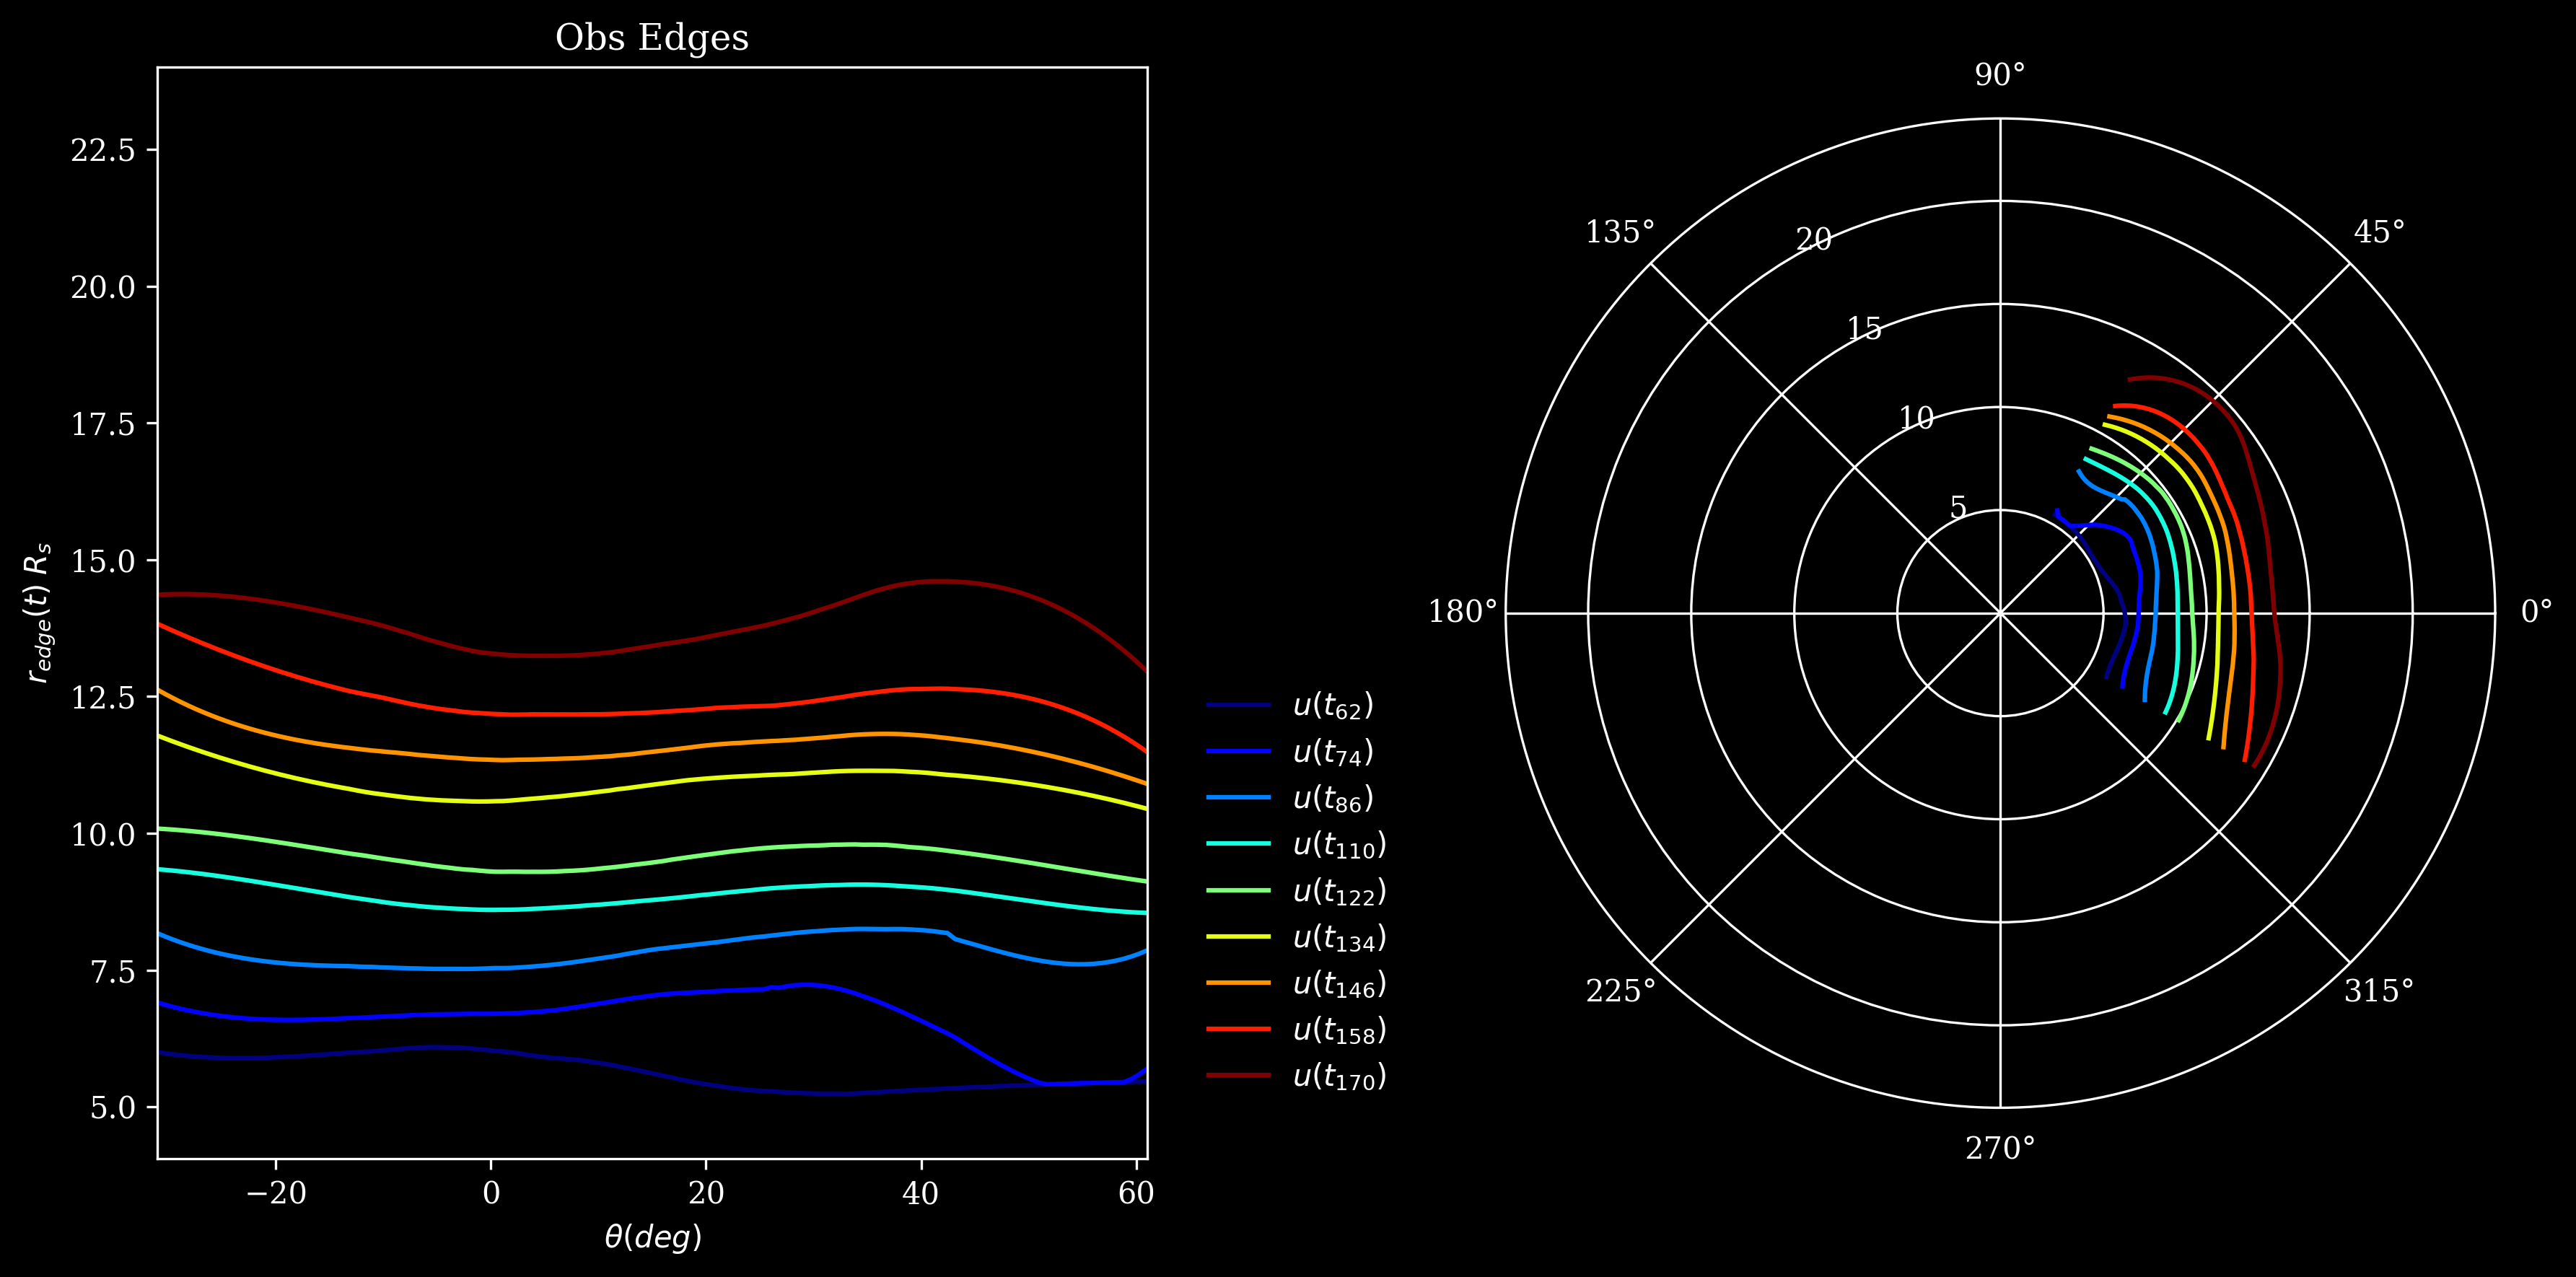

In [53]:
plotCartesianPolarEdgesObs(edge_obs_raw, theta=theta_grid_obs, saveFig=False)

In [54]:
# Save side by side sim and obs comparisons (for the `sim_idx_CR2161` time indices) 
# - could be useful! not right now.

def plotCartesianPolarEdgesObsScaled(edge_data_matrix, theta=theta_grid_obs, saveFig=False):
    
    # get minimum and max bounds (fixed for obs)
    tMinIdx = 30
    tMin = 62
    tMaxIdx = 84
    tMax = 170
        
    # convert edge data to polar coordinates
    r_vals, theta_vals = getRValuesObs(edge_data_matrix)
    
    # sim times (list all times)
    all_times = np.linspace(2, 180, 90)
    
    # filter based on tMinIdx and tMaxIdx
    valid_times = all_times[tMinIdx:(tMaxIdx + 1)]
    
    valid_times_to_plot = 62 + np.cumsum(np.array([0, 12, 12, 24, 12, 12, 12, 12, 12]))
    
    rescaled_times = (valid_times_to_plot - tMin) / (tMax - tMin) + 2
    valid_time_idx = (valid_times_to_plot / 2 - 1).astype(np.int64)
    
    fig = plt.figure(figsize=(12, 6))
    ax1 = plt.subplot(121)
    ax2 = plt.subplot(122, projection='polar')
        
    color = iter(plt.cm.jet(np.linspace(0, 1, len(valid_times_to_plot))))
    
    for i, j in enumerate(valid_time_idx):
        # ax1.plot(theta_vals[j, :] * (180 / np.pi), r_vals[j, :], color=next(color), label=fr"$u(t_{{{int(valid_times_to_plot[i])}}})$") # variable theta for each time??
        ax1.plot(theta, r_vals[i, :] / (rescaled_times[i] ** 2.25), color=next(color), label=fr"$u(t_{{{int(valid_times_to_plot[i])}}})$") # constant 
        # range of theta (usual plot)
        

    ax1.set_xlabel(r"$θ (deg)$")
    ax1.set_ylabel(r"$r_{edge}(t) \; R_s$")
    ax1.set_xlim(theta[0], theta[-1])
#     ax1.set_ylim(4.05, 24)
    ax1.legend(loc=(1.05, .05))
    ax1.set_title("Obs Edges")
    color = iter(plt.cm.jet(np.linspace(0, 1, len(valid_times_to_plot))))
    
    for i, j in enumerate(valid_time_idx):
        # ax2.plot(theta_vals[j, :], r_vals[j, :], color=next(color)) # variable theta for each time?
        ax2.plot(theta * np.pi/180, r_vals[i, :], color=next(color)) # constant range of theta (usual plot)

    ax2.set_rlabel_position(120)
    ax2.tick_params(axis='both', which='major', labelsize=10)
    ax2.set_rmax(24)
    ax2.grid(True)


    fig.tight_layout()
    
    plt.style.use("dark_background")
    if saveFig:
        plt.savefig("./Obs_2161.png",
                   bbox_inches="tight", pad_inches=0)
        plt.close()


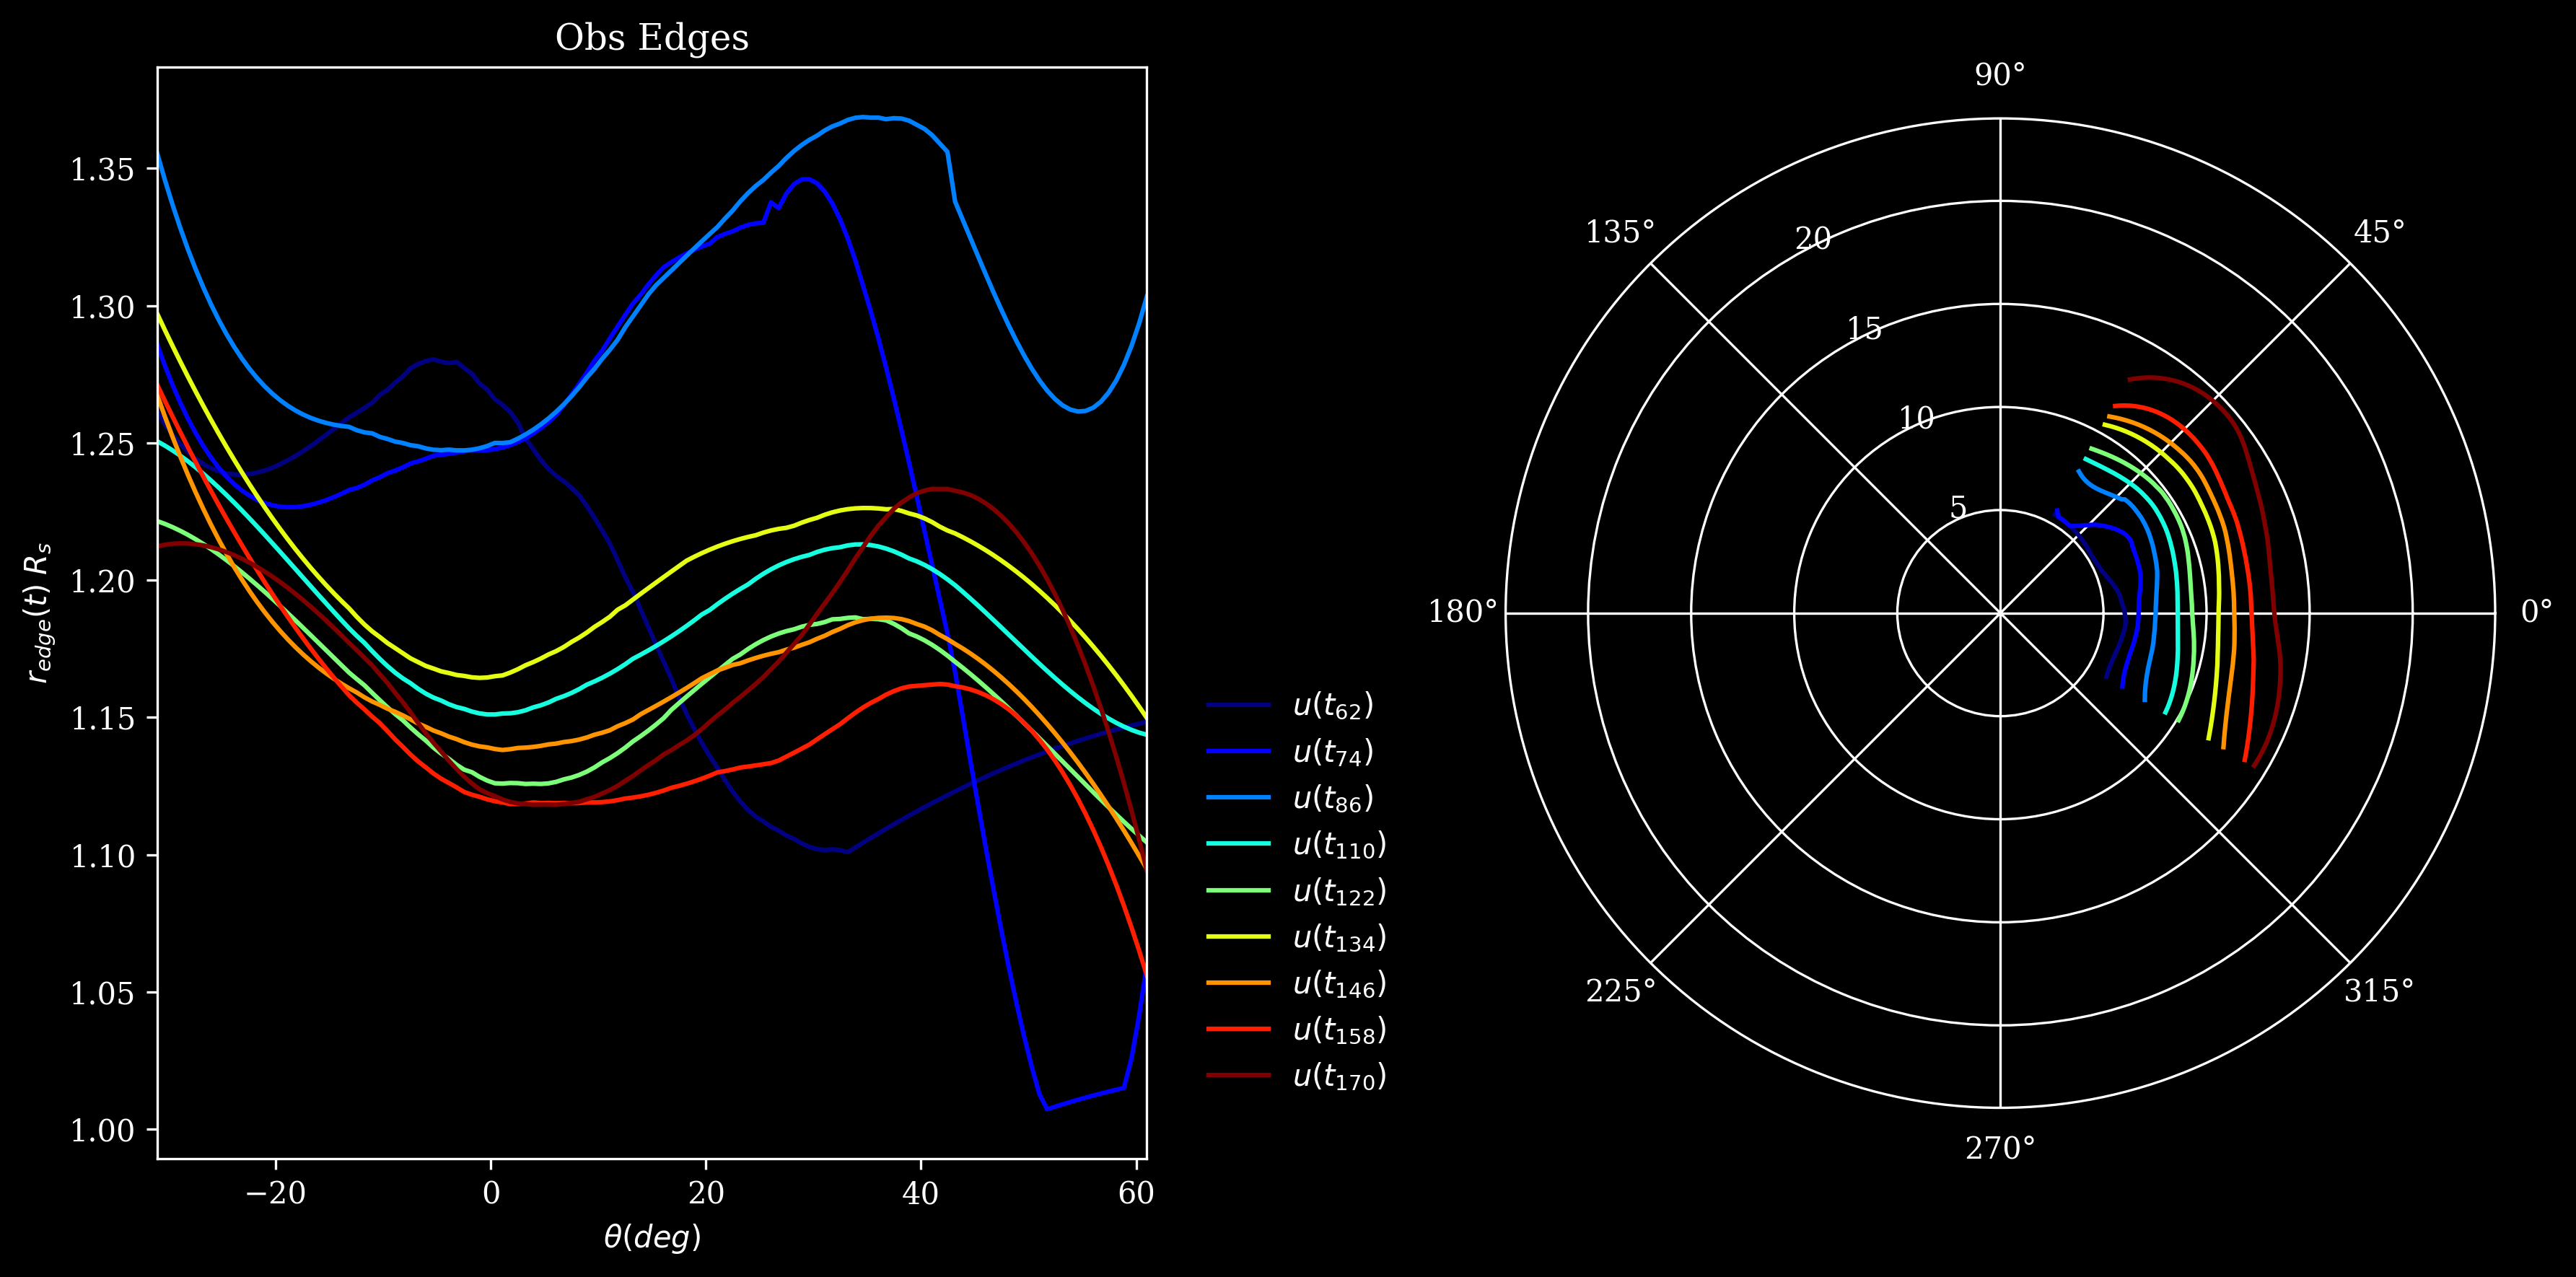

In [55]:
plotCartesianPolarEdgesObsScaled(edge_obs_raw, theta=theta_grid_obs, saveFig=False)

Note that varying $\theta$ for each time does not make a difference (variations are super small and original extraction was under a common $\theta$ range so its fine.

See if these modes collapse for different powers of $t$ in $r/t$. Before we tried powers $1$ and $0.5$. but we can try a grid (let's say 9?) and see how the modes look like at different powers.

In [56]:
pow_grid = np.array([0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2, 2.25])

In [57]:
23/(1**2.25)

23.0

In [58]:
23/(1 ** 0.25)

23.0

In [59]:
def plotPolarEdgesRescaled(edge_data_matrix, sim_data, theta=theta_grid, simIdx=0, saveFig=False, p_rescale=pow_grid,
                          edge_save_dir="./rescaled_edges"):
    
    # get Sim ID
    simID = sim_data[simIdx]
    
    # get minimum and max bounds (i.e. where edge appears and where edge is very close to boundary)
    tMinIdx, tMin, tMaxIdx, tMax = getTMinTMax(edge_data_matrix, simIdx=simIdx)
        
    # convert edge data to polar coordinates
    r_vals, theta_vals = getRValues(edge_data_matrix, simIdx=simIdx, minStartIdx=0)
    
    # sim times (list all times)
    all_times = np.linspace(2, 180, 90)
    
    # filter based on tMinIdx and tMaxIdx
    valid_times = all_times[tMinIdx:(tMaxIdx + 1)]
    
    valid_times_to_plot = np.arange(tMin, tMax + 2, step=6)
    
    times_rescaled = (valid_times_to_plot - tMin) / (tMax - tMin) + 2
    
    valid_time_idx = np.array([np.where(all_times == i)[0][0] for i in valid_times_to_plot])
    
    #     return valid_times_to_plot
    
    rmax_grid = [17, 14, 10, 8, 6, 4, 3.5, 3, 2.25]
    fig, axs = plt.subplots(3, 3, figsize=(13, 10), subplot_kw=dict(projection='polar'))
    for ax_idx, ax in enumerate(axs.ravel()):
        color = iter(plt.cm.jet(np.linspace(0, 1, len(valid_times_to_plot))))
        for i, j in enumerate(valid_time_idx):
            # ax1.plot(theta_vals[j, :] * (180 / np.pi), r_vals[j, :], color=next(color), label=fr"$u(t_{{{int(valid_times_to_plot[i])}}})$") # variable theta for each time??
            ax.plot(theta * np.pi / 180, r_vals[j, :] / ((times_rescaled[i]) ** p_rescale[ax_idx]), color=next(color), label=fr"$u(t_{{{int(valid_times_to_plot[i])}}})$") # constant 
            # range of theta (usual plot)
            #             ax.set_xlabel(r"$θ (deg)$")
            #             ax.set_ylabel(r"$r_{edge}(t) \; R_s$")
            ax.set_rlabel_position(120)
            ax.set_rmax(rmax_grid[ax_idx])
            ax.tick_params(axis='both', which='major', labelsize=10)
#             ax.legend(loc=(1.05, .05))
            ax.grid(True)
    
        ax.set_title("Pow = {}".format(p_rescale[ax_idx]))

    handles, labels = axs.ravel()[-1].get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(1.05, 0.05))
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle("Sim {:03d}".format(simID))
    fig.tight_layout()
    
    plt.style.use("dark_background")
    if saveFig:
        plt.savefig(os.path.join(edge_save_dir, "run_{:03d}.png".format(simID)),
                   bbox_inches="tight", pad_inches=0)
        print("Saved image for Sim {:03d}".format(simID))
        plt.close()

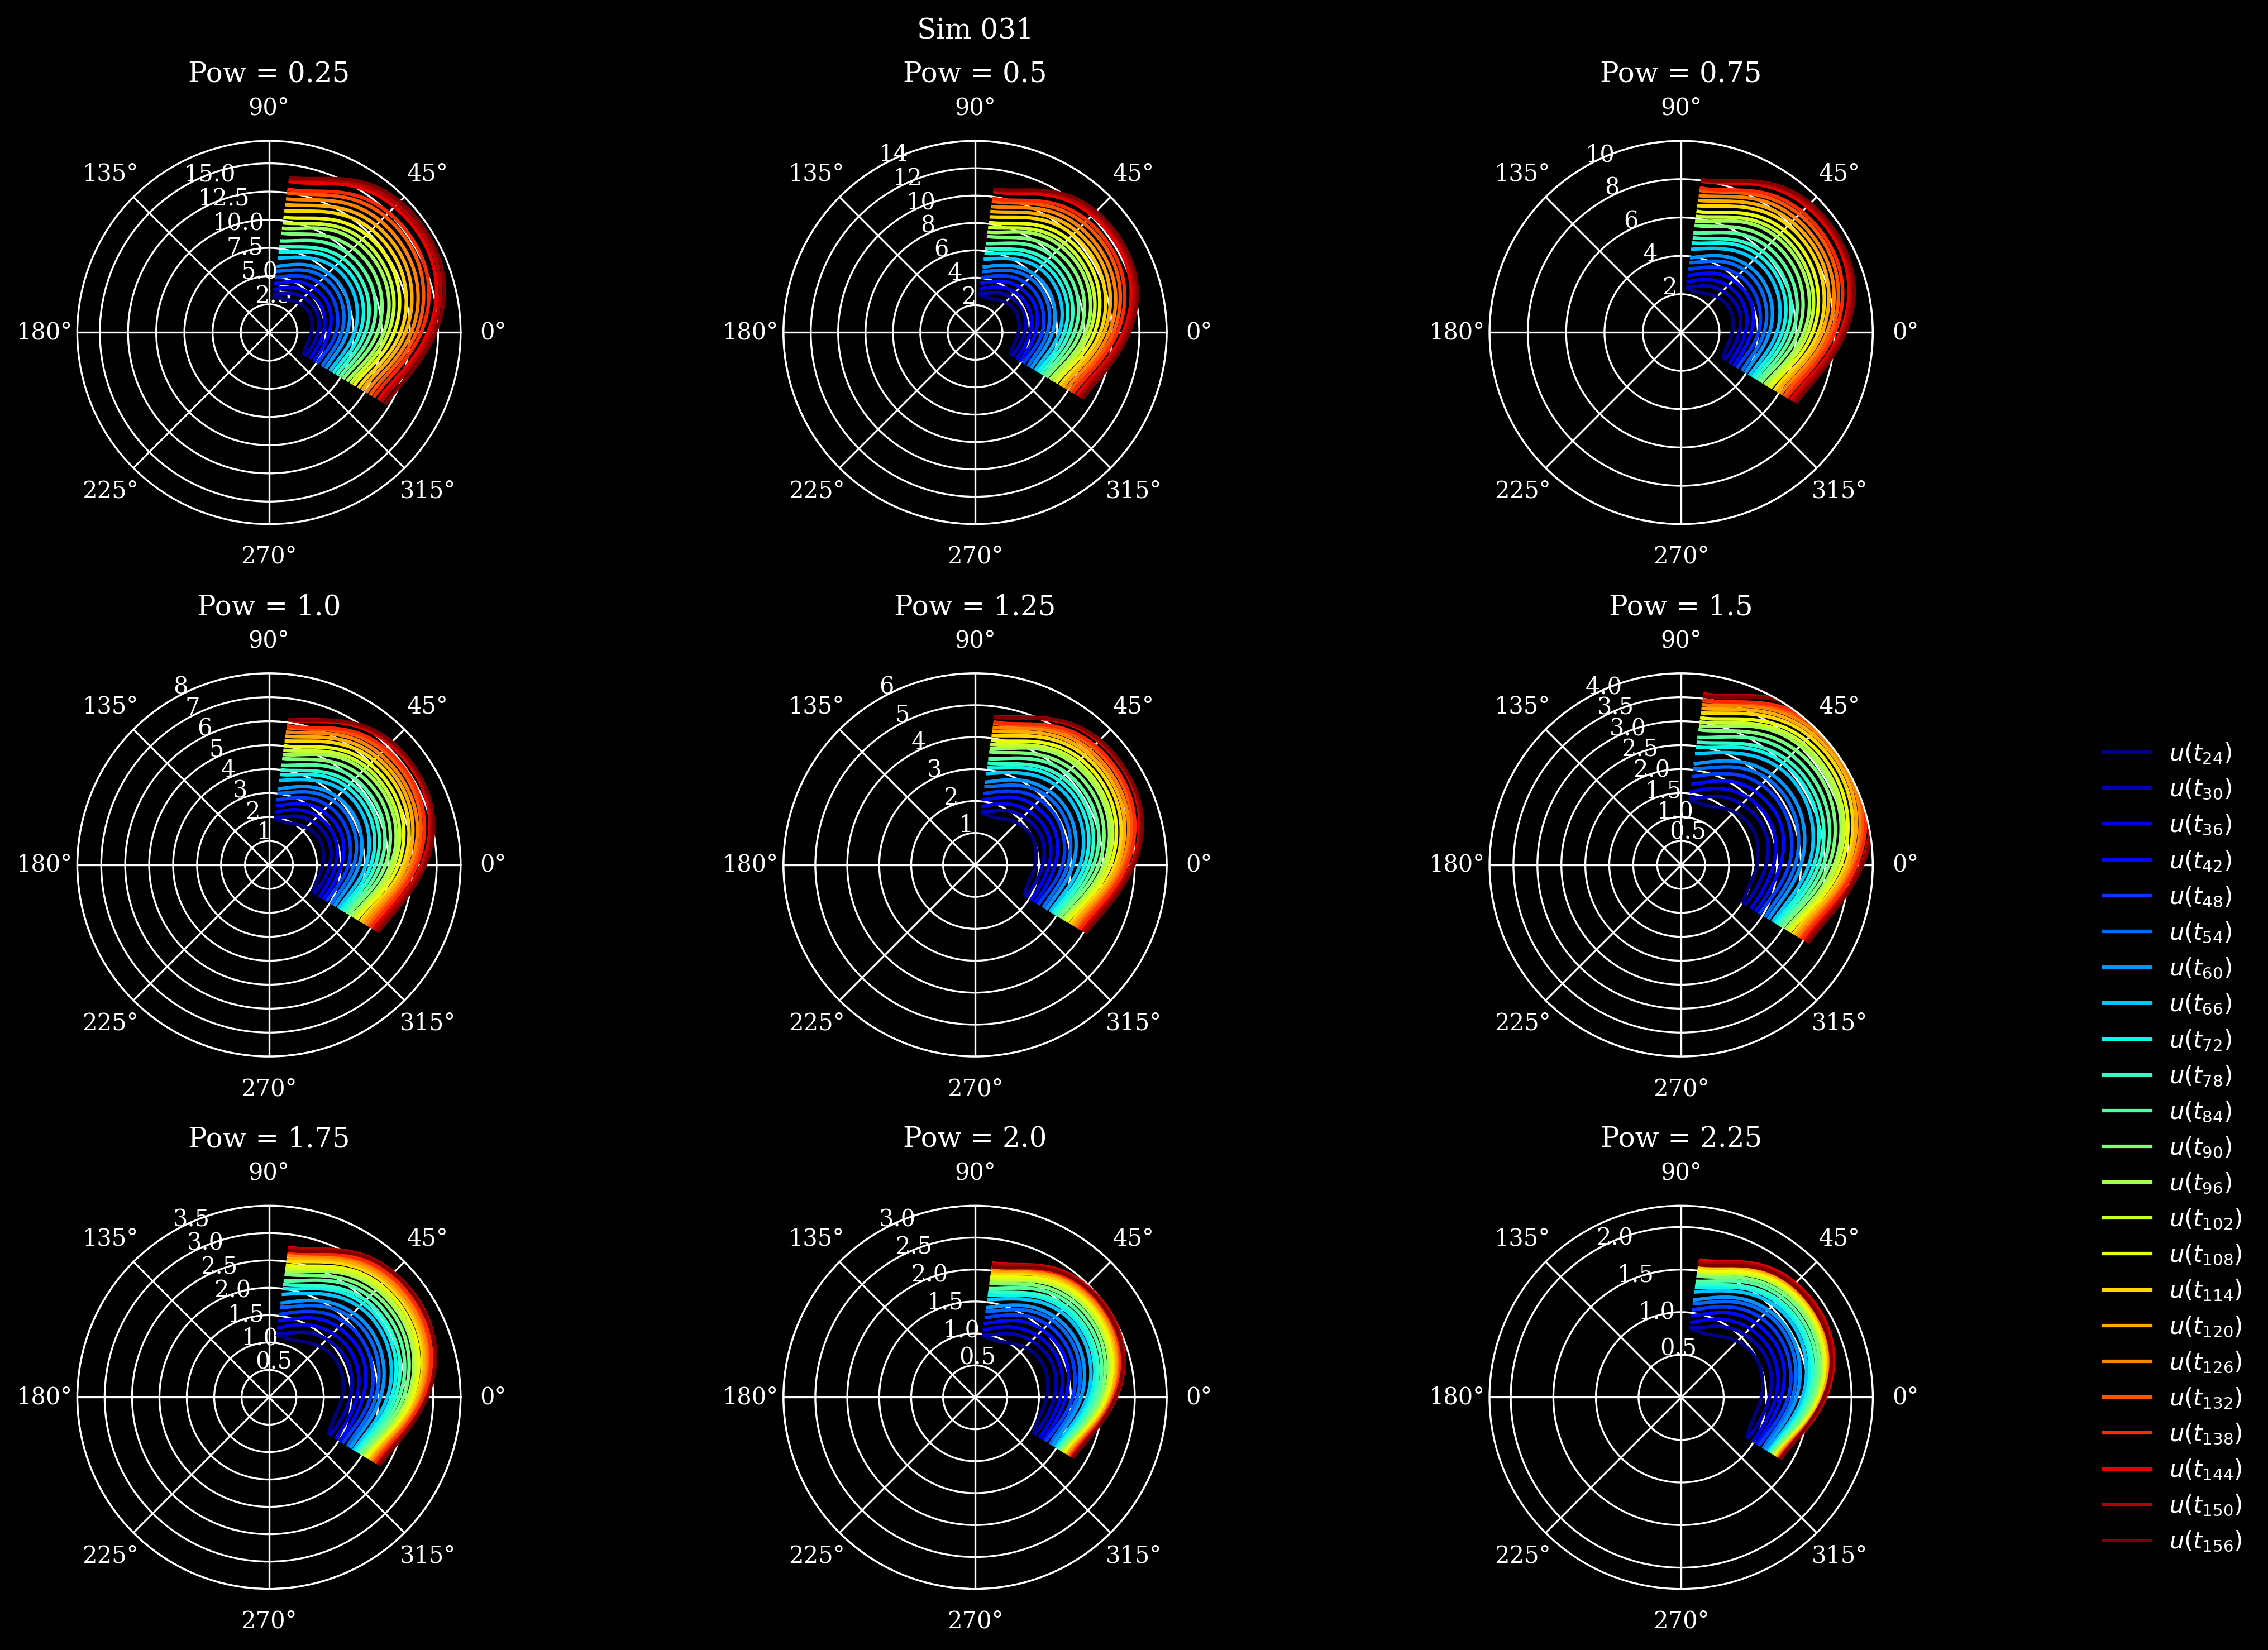

In [60]:
plotPolarEdgesRescaled(ed_2161, sd_2161, theta=theta_grid, simIdx=0, p_rescale=pow_grid)

In [61]:
# for i in range(len(sd_2161)):
#     plotPolarEdgesRescaled(ed_2161, sd_2161, theta=theta_grid, simIdx=i, saveFig=True)

**Cases of acceleration and deceleration**

Deceleration to complete rest in long time limit.

In [62]:
def RDecel(edge_data_matrix, sim_data, theta=theta_grid, simIdx=0, saveFig=False):
    # get Sim ID
    simID = sim_data[simIdx]
    
    # get minimum and max bounds (i.e. where edge appears and where edge is very close to boundary)
    tMinIdx, tMin, tMaxIdx, tMax = getTMinTMax(edge_data_matrix, simIdx=simIdx)
        
    # convert edge data to polar coordinates
    r_vals, theta_vals = getRValues(edge_data_matrix, simIdx=simIdx, minStartIdx=0)
    
    
    # sim times (list all times)
    all_times = np.linspace(2, 180, 90)
    
    # filter based on tMinIdx and tMaxIdx
    valid_times = all_times[tMinIdx:(tMaxIdx + 1)]
    
    valid_times_to_plot = np.arange(tMin, tMax + 2, step=6)
    
    valid_time_idx = np.array([np.where(all_times == i)[0][0] for i in valid_times_to_plot])
    
    #     return valid_times_to_plot
    
    
    fig = plt.figure(figsize=(12, 6))
    ax1 = plt.subplot(121, projection='polar')
    ax2 = plt.subplot(122, projection='polar')
        
    color = iter(plt.cm.jet(np.linspace(0, 1, len(valid_times_to_plot))))
    
    for i, j in enumerate(valid_time_idx):
        ax1.plot(theta * np.pi/180, r_vals[j, :], color=next(color), label=fr"$u(t_{{{int(valid_times_to_plot[i])}}})$")
        

    ax1.set_rlabel_position(120)
    ax1.tick_params(axis='both', which='major', labelsize=10)
    ax1.set_rmax(24)
    ax1.grid(True)
    ax1.legend(loc=(1.05, .05))
    ax1.set_title("Sim {:03d} original".format(simID))

    color = iter(plt.cm.jet(np.linspace(0, 1, len(valid_times_to_plot))))
    
    r0 = r_vals[valid_time_idx[0], :]
    
    for i, j in enumerate(valid_time_idx):
        if i == 0:
            ax2.plot(theta * np.pi/180, r0, color=next(color))
        else:
            ax2.plot(theta * np.pi/180, r0 * (0.015 ** (7/12)) * (valid_times_to_plot[i] ** (7/9)), color=next(color)) # constant range of theta (usual plot)

    ax2.set_rlabel_position(120)
    ax2.tick_params(axis='both', which='major', labelsize=10)
    ax2.set_rmax(24)
    ax2.grid(True)
    ax2.set_title("Sim {:03d} Predicted".format(simID))
    
    fig.tight_layout()
    
    plt.style.use("dark_background")

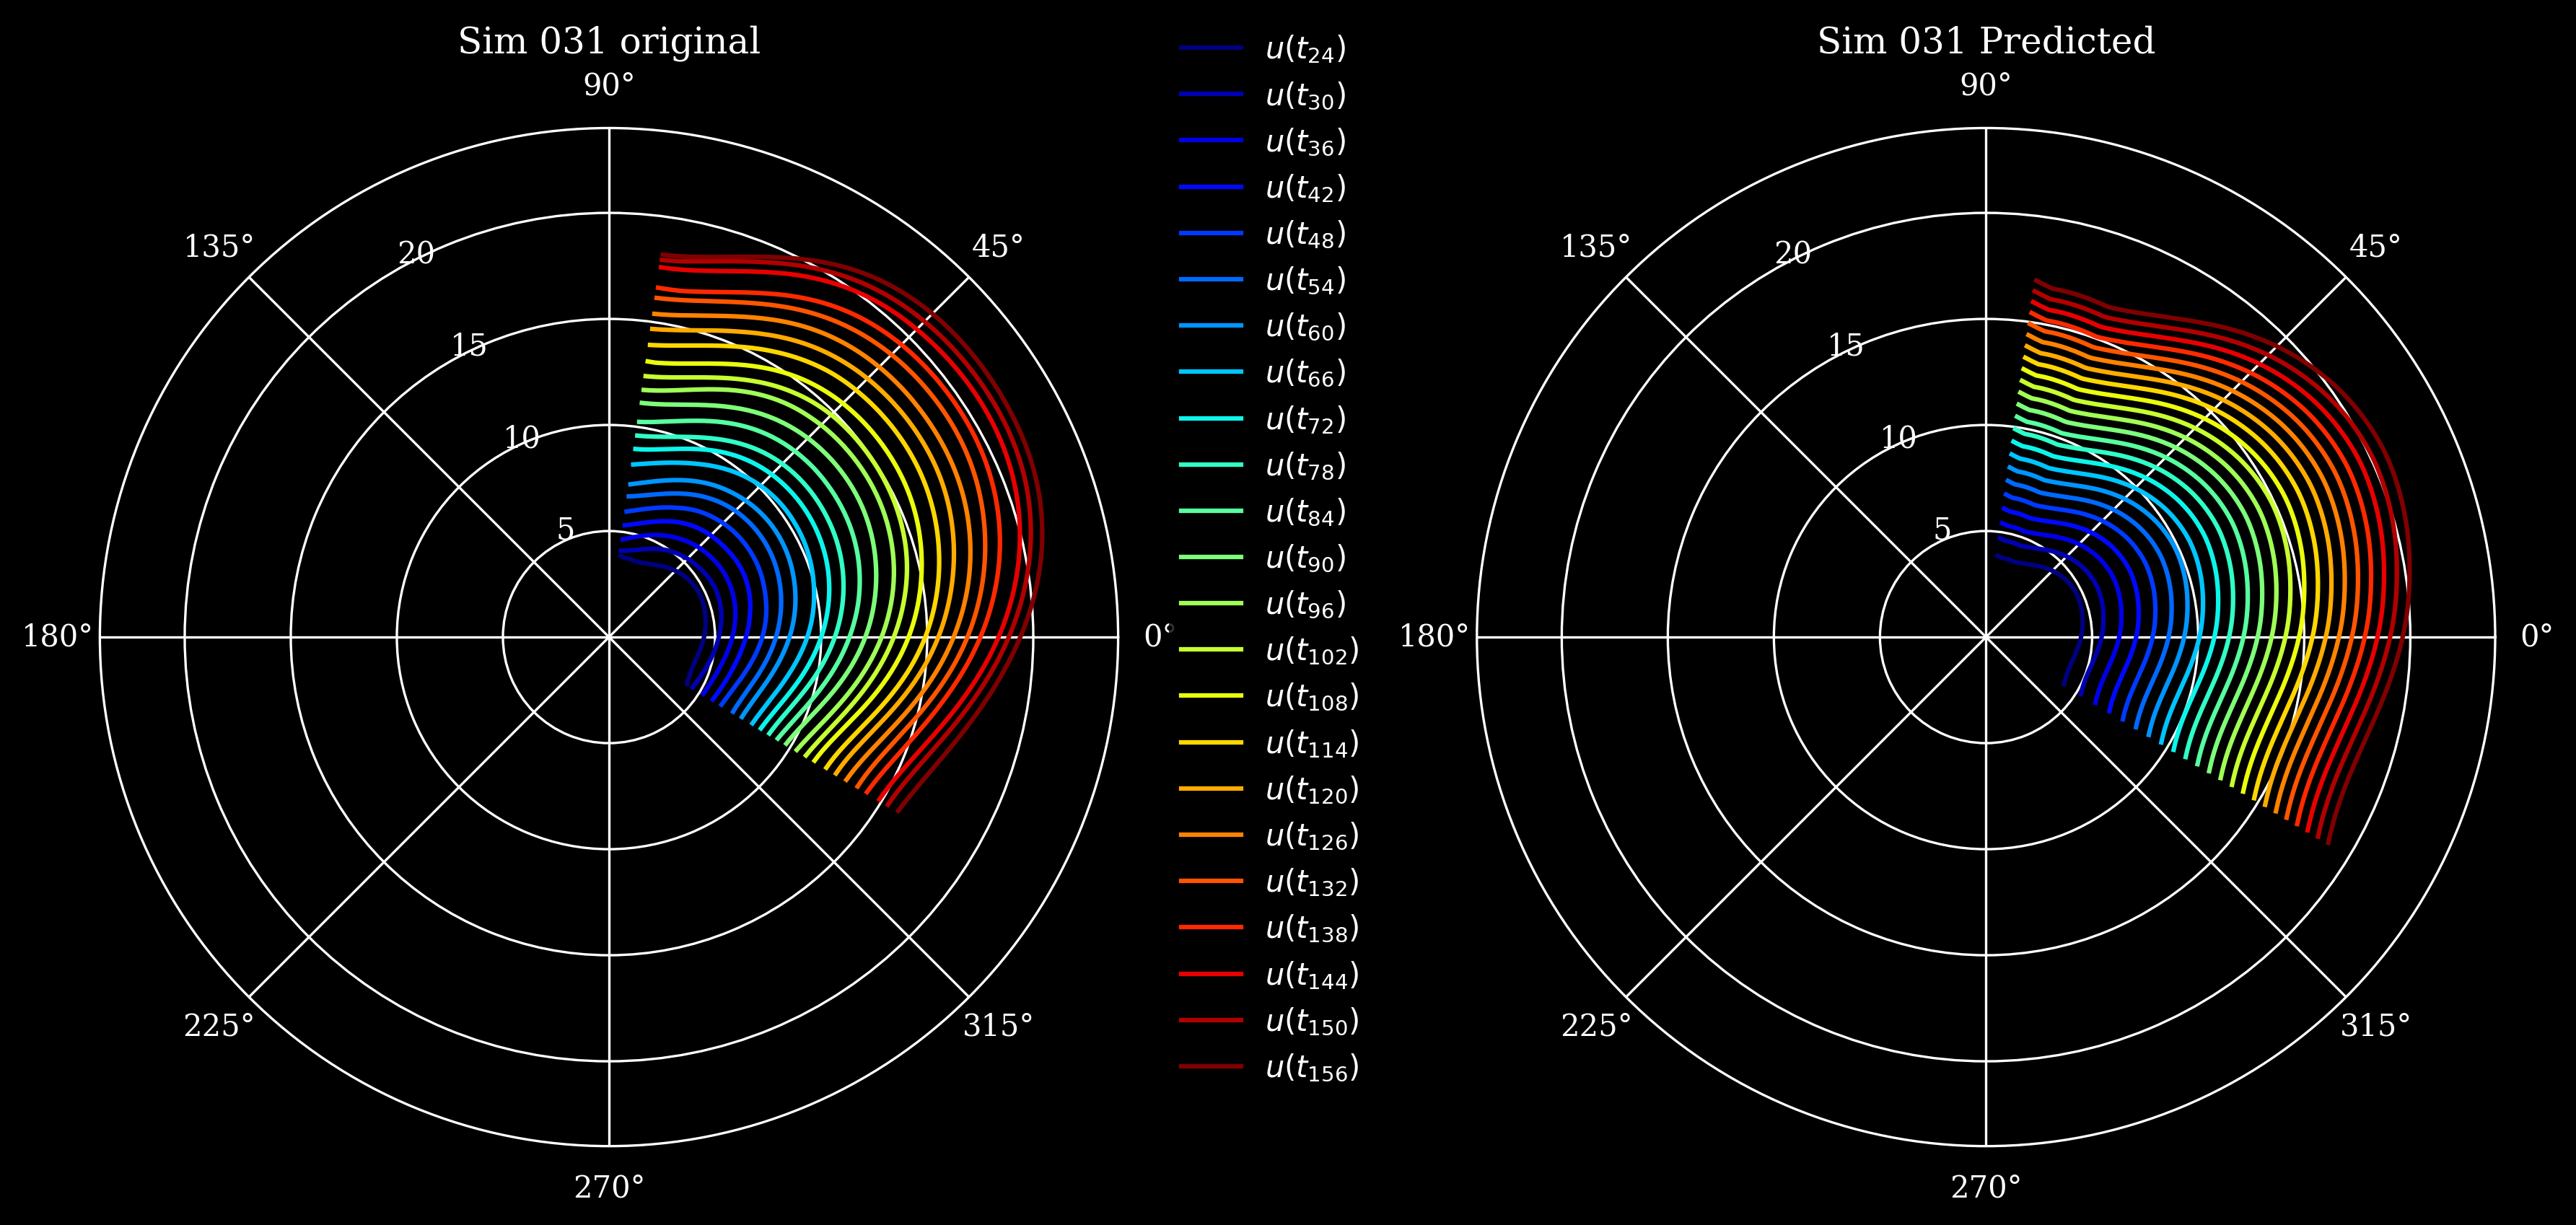

In [63]:
RDecel(ed_2161, sd_2161, theta=theta_grid, simIdx=0) # this approach is not very different from scaling by different
# values of time and is low reward. 

Checking different forms like exponential etc.

Assume $\frac{dr}{dt} = k \exp(-t / \tau)$,

Solve $\log (r - r_0) = \log (- k \tau) + ( - t / \tau)$

In [65]:
def getExpConstants(edge_data_matrix, sim_data, theta=theta_grid, simIdx=0, saveFig=False):
    simID = sim_data[simIdx]
    
    # get minimum and max bounds (i.e. where edge appears and where edge is very close to boundary)
    tMinIdx, tMin, tMaxIdx, tMax = getTMinTMax(edge_data_matrix, simIdx=simIdx)
        
    # convert edge data to polar coordinates
    r_vals, theta_vals = getRValues(edge_data_matrix, simIdx=simIdx, minStartIdx=0)
    
    
    # sim times (list all times)
    all_times = np.linspace(2, 180, 90)
    
    # filter based on tMinIdx and tMaxIdx
    valid_times = all_times[tMinIdx:(tMaxIdx + 1)]
    
    valid_times_to_plot = np.arange(tMin, tMax + 2, step=6)
    
    valid_time_idx = np.array([np.where(all_times == i)[0][0] for i in valid_times_to_plot])
    
    rescaled_times = (valid_times_to_plot - tMin) / (tMax - tMin)
    
    r0 = r_vals[valid_time_idx[0], 80]
    
    r_exp = np.log(r_vals[valid_time_idx[1:], 80] - r0)
    
    A = np.vstack([rescaled_times[1:], np.ones(len(rescaled_times[1:]))]).T
        
    #     return A, r_exp, valid_time_idx

    m, c = np.linalg.lstsq(A, r_exp, rcond=None)[0]

    tau = -1/m
    k = - np.exp(c) / tau

    return k, tau

In [121]:
k0, tau0 = getExpConstants(ed_2161, sd_2161, theta=theta_grid, simIdx=0)

In [125]:
k0, tau0

(4.842838821281053, -0.3707980673408288)

In [124]:
k1, tau1 = getExpConstants(ed_2161, sd_2161, theta=theta_grid, simIdx=1)
print(k1, tau1)

1.6066984619907876 -0.42167681927293266


In [126]:
sd_2161

array([ 31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,  43,
        44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  56,  57,
        58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,
        71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
        84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,
        97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 110,
       111, 112, 113, 114, 115, 118, 119, 120, 121, 122, 123, 124, 126,
       127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 138, 139, 140,
       141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153,
       154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 166, 168,
       169, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 183,
       184, 185, 186, 188, 190, 191, 192, 193, 194, 196, 197, 198, 199,
       200, 201, 202, 203, 204, 205, 206, 208, 209, 210, 211, 212, 213,
       214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 22

In [118]:
# generally an overdetermined system

In [128]:
k_all_sims = []
tau_all_sims = []

for i in range(len(sd_2161)):
    k, tau = getExpConstants(ed_2161, sd_2161, theta=theta_grid, simIdx=i)
    k_all_sims.append(k)
    tau_all_sims.append(tau)
    print("Solved for Sim {}".format(sd_2161[i]))

Solved for Sim 31
Solved for Sim 32
Solved for Sim 33
Solved for Sim 34
Solved for Sim 35
Solved for Sim 36
Solved for Sim 37
Solved for Sim 38
Solved for Sim 39
Solved for Sim 40
Solved for Sim 41
Solved for Sim 42
Solved for Sim 43
Solved for Sim 44
Solved for Sim 45
Solved for Sim 46
Solved for Sim 47
Solved for Sim 48
Solved for Sim 49
Solved for Sim 50
Solved for Sim 51
Solved for Sim 52
Solved for Sim 53
Solved for Sim 54
Solved for Sim 56
Solved for Sim 57
Solved for Sim 58
Solved for Sim 59
Solved for Sim 60
Solved for Sim 61
Solved for Sim 62
Solved for Sim 63
Solved for Sim 64
Solved for Sim 65
Solved for Sim 66
Solved for Sim 67
Solved for Sim 68
Solved for Sim 69
Solved for Sim 70
Solved for Sim 71
Solved for Sim 72
Solved for Sim 73
Solved for Sim 74
Solved for Sim 75
Solved for Sim 76
Solved for Sim 77
Solved for Sim 78
Solved for Sim 79
Solved for Sim 80
Solved for Sim 81
Solved for Sim 82
Solved for Sim 83
Solved for Sim 84
Solved for Sim 85
Solved for Sim 86
Solved for

<ipython-input-113-cc0771aec2db>:25: RuntimeWarning: divide by zero encountered in log
  r_exp = np.log(r_vals[valid_time_idx[1:], 80] - r0)


Solved for Sim 123
Solved for Sim 124
Solved for Sim 126
Solved for Sim 127
Solved for Sim 128
Solved for Sim 129
Solved for Sim 130
Solved for Sim 131
Solved for Sim 132
Solved for Sim 133
Solved for Sim 134
Solved for Sim 135
Solved for Sim 136
Solved for Sim 138
Solved for Sim 139
Solved for Sim 140
Solved for Sim 141
Solved for Sim 142
Solved for Sim 143
Solved for Sim 144
Solved for Sim 145
Solved for Sim 146
Solved for Sim 147
Solved for Sim 148
Solved for Sim 149
Solved for Sim 150
Solved for Sim 151
Solved for Sim 152
Solved for Sim 153
Solved for Sim 154
Solved for Sim 155
Solved for Sim 156
Solved for Sim 157
Solved for Sim 158
Solved for Sim 159
Solved for Sim 160
Solved for Sim 161
Solved for Sim 162
Solved for Sim 163
Solved for Sim 164
Solved for Sim 166
Solved for Sim 168
Solved for Sim 169
Solved for Sim 171
Solved for Sim 172
Solved for Sim 173
Solved for Sim 174
Solved for Sim 175
Solved for Sim 176
Solved for Sim 177
Solved for Sim 178
Solved for Sim 179
Solved for S

<ipython-input-113-cc0771aec2db>:33: RuntimeWarning: divide by zero encountered in double_scalars
  tau = -1/m


Solved for Sim 222
Solved for Sim 223
Solved for Sim 224
Solved for Sim 225
Solved for Sim 226
Solved for Sim 227
Solved for Sim 228
Solved for Sim 229
Solved for Sim 230
Solved for Sim 231
Solved for Sim 232
Solved for Sim 233
Solved for Sim 234
Solved for Sim 235
Solved for Sim 236
Solved for Sim 237
Solved for Sim 238
Solved for Sim 239
Solved for Sim 240
Solved for Sim 241
Solved for Sim 242
Solved for Sim 243
Solved for Sim 244
Solved for Sim 246
Solved for Sim 247
Solved for Sim 248
Solved for Sim 249
Solved for Sim 251
Solved for Sim 252
Solved for Sim 253
Solved for Sim 254
Solved for Sim 255
Solved for Sim 256
Solved for Sim 257
Solved for Sim 258
Solved for Sim 259
Solved for Sim 260
Solved for Sim 261
Solved for Sim 262
Solved for Sim 263
Solved for Sim 264
Solved for Sim 265
Solved for Sim 266
Solved for Sim 267
Solved for Sim 268
Solved for Sim 269
Solved for Sim 271
Solved for Sim 272
Solved for Sim 273
Solved for Sim 274
Solved for Sim 275
Solved for Sim 276
Solved for S

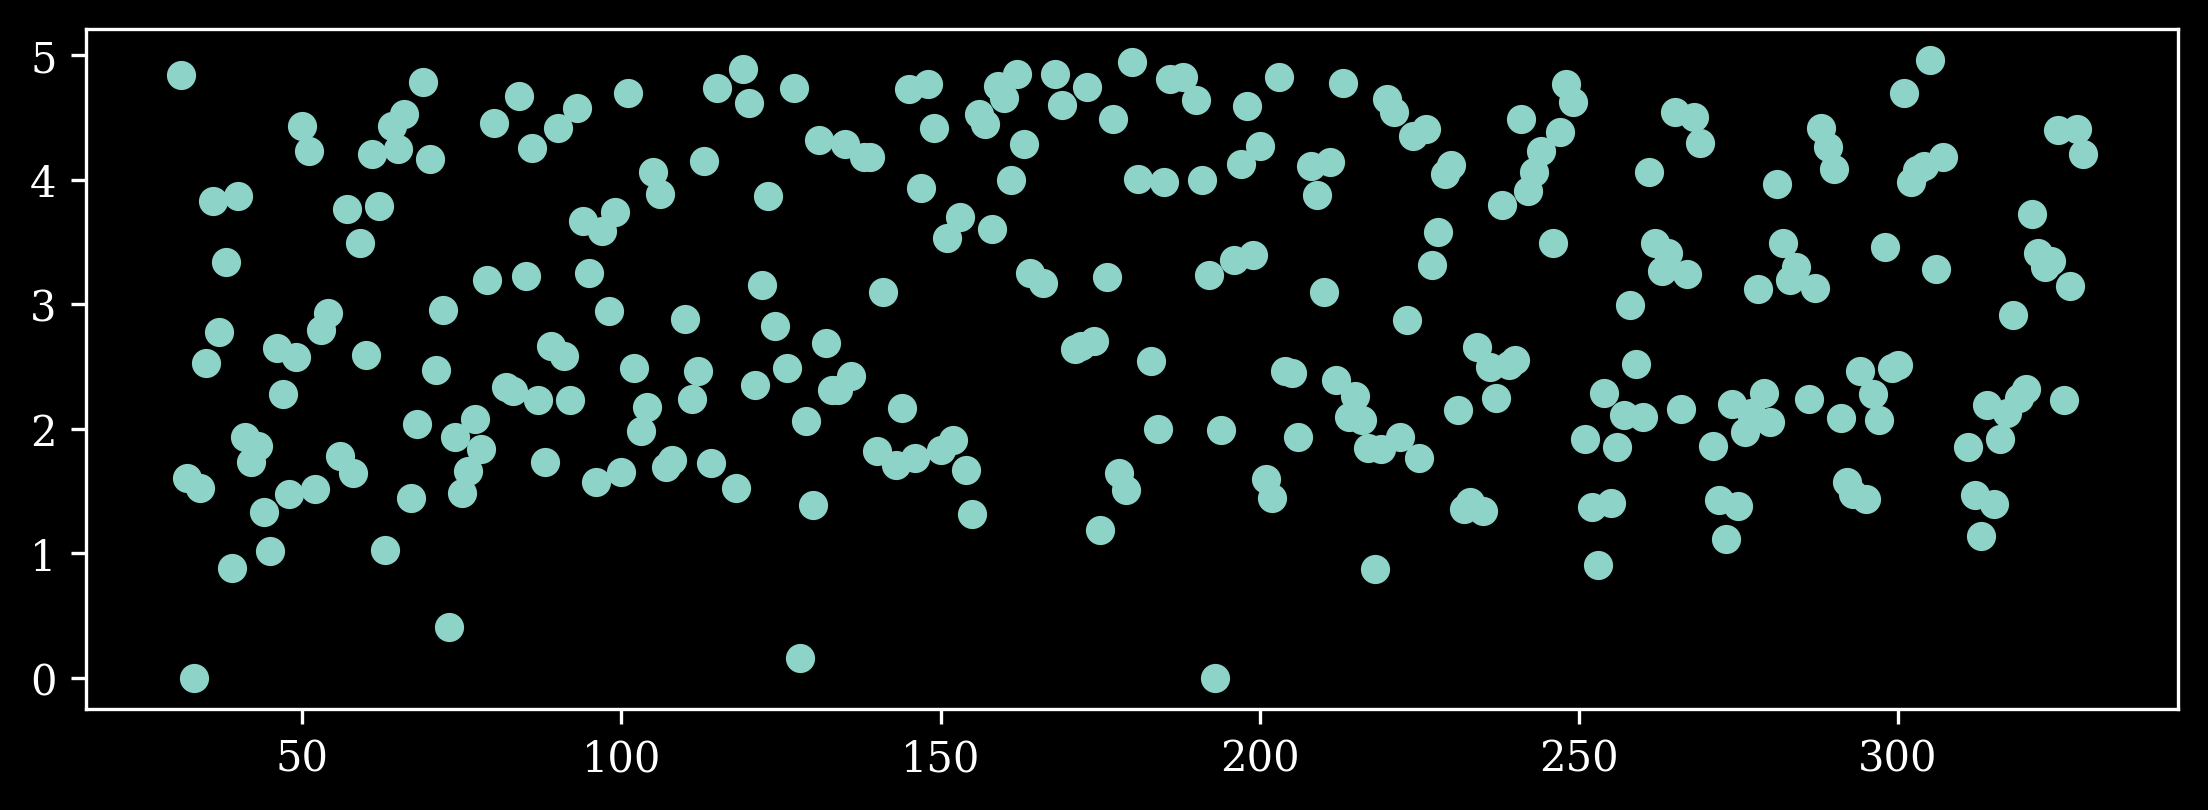

In [129]:
plt.scatter(sd_2161, k_all_sims)

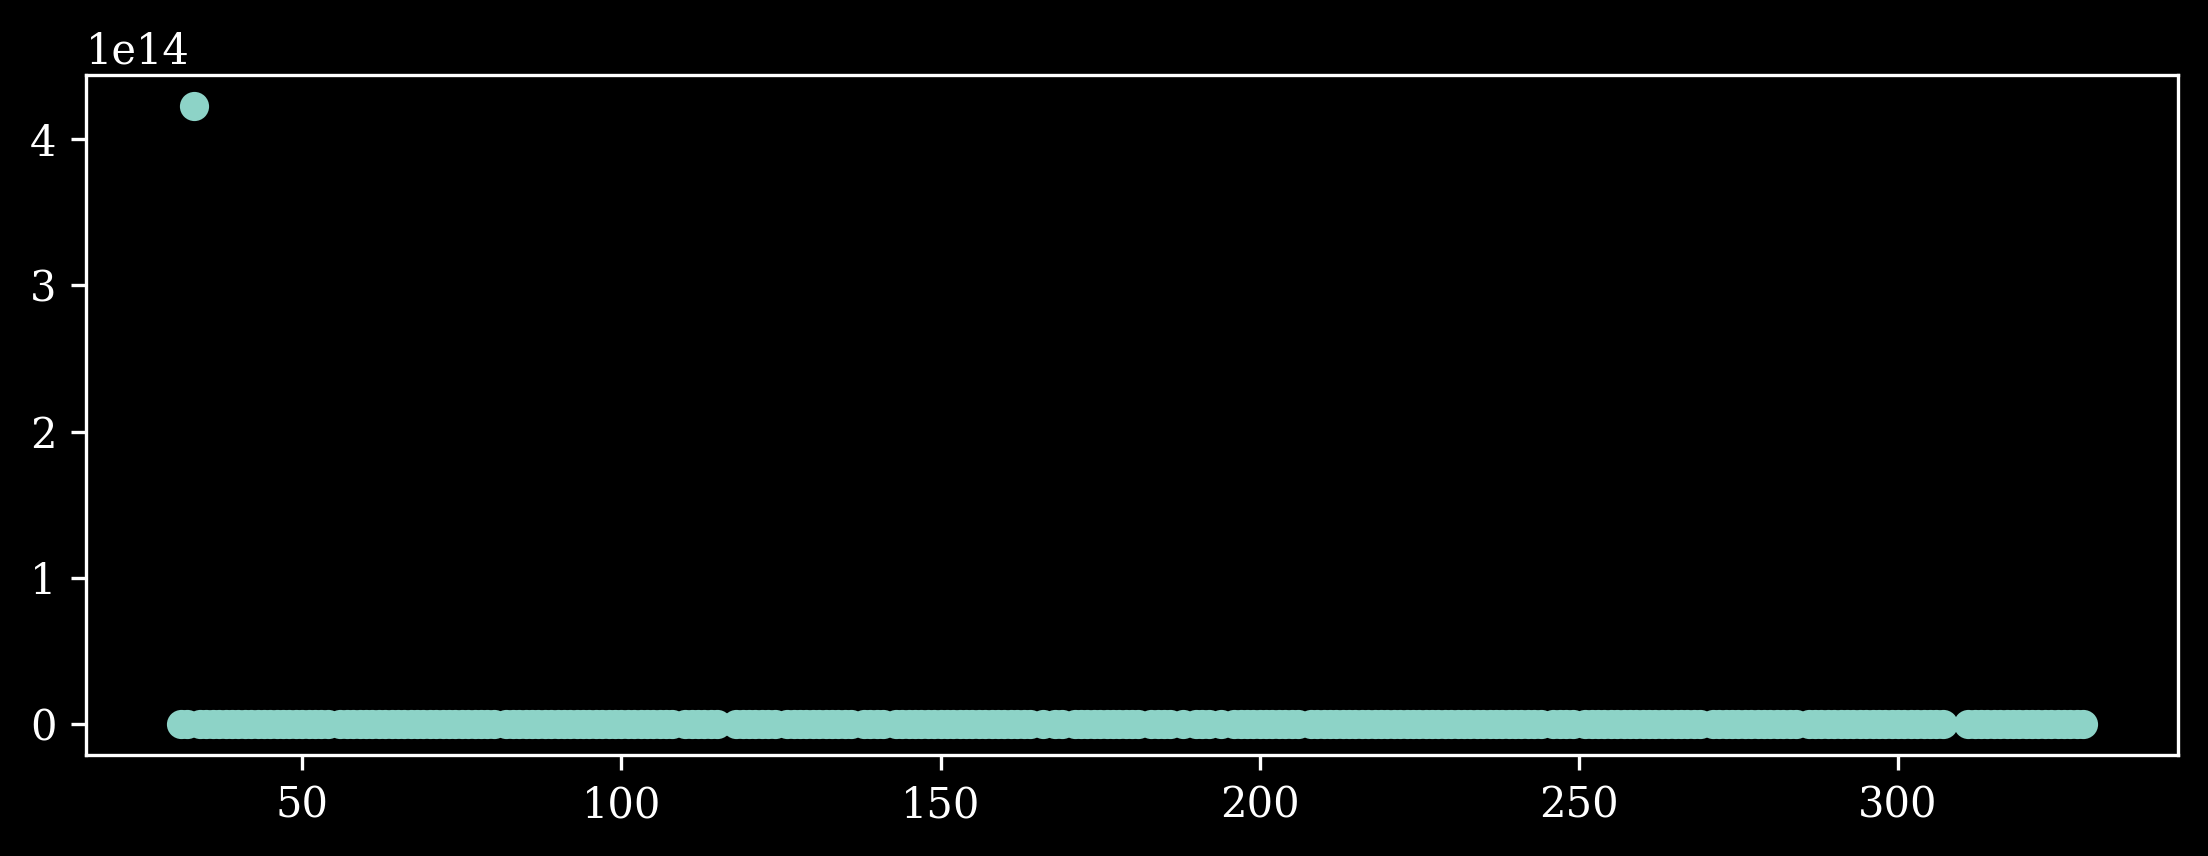

In [138]:
plt.scatter(sd_2161, tau_all_sims)
# plt.ylim(-0.2, 0.2)

In [139]:
tau_all_sims

[-0.3707980673408288,
 -0.42167681927293266,
 422480922823562.4,
 -0.3857344117776574,
 -0.3705328887727313,
 -0.38297239617372086,
 -0.38995830620902,
 -0.3604065417763361,
 -0.5667255727027434,
 -0.35663447203967125,
 -0.3396625195914584,
 -0.4099404369506877,
 -0.34853249483540155,
 -0.416188616740925,
 -0.4308005783982878,
 -0.39199593116910875,
 -0.4091961522221767,
 -0.34746783550070187,
 -0.3575919779948576,
 -0.39040883270727206,
 -0.4081192065087293,
 -0.5119417702538208,
 -0.2875262471828254,
 -0.36073931406729526,
 -0.35581116524567075,
 -0.3689929699558594,
 -0.3528966466773298,
 -0.3802434985717545,
 -0.3172607985642204,
 -0.3700825743546264,
 -0.35604260754815914,
 -0.6221948521850872,
 -0.36166109143923925,
 -0.3863222853741665,
 -0.3841333600097139,
 -0.4038983849323538,
 -0.32040385637458,
 -0.38608276843380035,
 -0.37245825215277845,
 -0.3749487030089391,
 -0.37976711973046584,
 -1.4851435701845461,
 -0.38497247576942983,
 -0.39083997735418846,
 -0.4048451248833567,
 

In [112]:
# repeat for all sims first, and plot one sim with this reconstruction to check. Then we can think of holding out
# data, parametrizing k and tau and so on.

In [111]:
# check if prediction holds when fitting to limited data.

In [63]:
import pysindy as ps

In [68]:
poly_library = ps.PolynomialLibrary(include_bias=False)
fourier_library = ps.FourierLibrary()

library_functions = [lambda x: np.exp(-x)]
library_function_names = [
    lambda x: "1.0 / (" + x + " + 100)",
    lambda x: "exp(-" + x + ")",
]

combined_library = poly_library * fourier_library

In [94]:
# plotCartesianPolarEdges(ed_2161, sd_2161, theta=theta_grid, simIdx=1)

In [93]:
# plotCartesianPolarEdges(ed_2161, sd_2161, theta=theta_grid, simIdx=2)

In [92]:
# plotCartesianPolarEdges(ed_2161, sd_2161, theta=theta_grid, simIdx=3)

SOpInf style, we could shift and scale first, but then the drawback is that the shift learning process is not explicitly parametrized? Maybe then the shifting problem could just be treated separately, i.e.

**Model 1**: Given new $\theta^\ast$, predict $c(\theta^\ast)$ based on training set

**Model 2**: Predict $\hat{f}(\theta^\ast, r/t)$ and then shift back to advection coordinates (add $c(\theta^\ast) \times t$) to get $f(\theta^\ast, r, t)$

**Non linear dimensionality Reduction - Diffusion Maps?**

[Coifman and Lafon, 2006 - Diffusion Maps](https://doi.org/10.1016/j.acha.2006.04.006)

[Winstead, 2017, Nonlinear MOR based on Manifold Learning](https://trace.tennessee.edu/cgi/viewcontent.cgi?article=5535&context=utk_gradthes)

In [ ]:
# sampleTimeIdx = [0, 2, 4, 8, 12, 20, 40, 50, 60, 66, 69]
# sampleTimesToPlot = actualTimes[20:][sampleTimeIdx]

In [ ]:
# fig = plt.figure(figsize=(12, 6))
# ax1 = plt.subplot(121)
# ax2 = plt.subplot(122, projection='polar')

# sampleTimeIdx = [0, 2, 4, 8, 12, 20, 40, 50, 60, 66, 69]
# sampleTimesToPlot = actualTimes[20:][sampleTimeIdx]

# color = iter(plt.cm.viridis(np.linspace(0, 1, len(sampleTimesToPlot))))

# theta = np.linspace(-32, 82, 160)

# for i, j in enumerate(sampleTimeIdx):
#     ax1.plot(theta, r_vals_s31[j, :], color=next(color), label=fr"$u(t_{{{sampleTimesToPlot[i]}}})$")

# ax1.set_xlabel(r"$θ (deg)$")
# ax1.set_ylabel(r"$r_{edge}(t)$")
# ax1.set_xlim(-32, 82)
# ax1.set_ylim(4.05, 24)
# ax1.legend(loc=(1.05, .05))
# ax1.set_title("Sim 031")

# color = iter(plt.cm.viridis(np.linspace(0, 1, len(sampleTimesToPlot))))


# for i, j in enumerate(sampleTimeIdx):
#     ax2.plot(theta * np.pi/180, r_vals_s31[j, :], color=next(color), label=fr"$u(t_{{{sampleTimesToPlot[i]}}})$")

# ax2.tick_params(axis='both', which='major', labelsize=10)
# ax2.set_rmax(24)
# ax2.grid(True)


# fig.tight_layout()